<font face="Arial">
<h1> <center> <font size="6"> <b>  Hapke models for intimate mixtures of ice and lunar regolith </b> </font>  </center></h1>
<font size="4"> <b> Erin Pimentel </b> <br>
<font> <b> Last Updated: Oct. 7, 2024 </b> </font>

___

<b> Notebook Outline </b>

1.0 [Background](#section-1.0)<br>
2.0 [Theory (Hapke 1993, 2012)](#section-2.0)<br>
3.0 [Implementation](#section-3.0)<br>
> 3.1 [ How does ice grain size influence its single-scattering albedo?](#section-3.1) <br>
> 3.2 [What role does porosity play in the relationship between single-scattering albedo and reflectance?](#section-3.2) <br>
> 3.3 [How does reflectance change as ice grain size, bulk porosity, and water ice concentration vary?](#section-3.3) <br>

## 1.0 Background
<a id="section-1.0"> </a>

In this notebook, I use Hapke theory to model intimate mixtures of lunar regolith and ice for comparison to reflectance measurements collected by the Lunar Reconnaissance Orbiter (LRO). <b> I will use two albedo datasets from LRO:
1. <b>The Lunar Orbiter Laser Altimeter (LOLA) 1064 nm surface albedo data
2. <b>The Lyman-Alpha Mapping Project (LAMP) Ly-$\alpha$ band albedo data
   
As early as the 1960s, water ice was theorized to exist in Permanently Shadowed Regions (PSRs) at the Moon’s north and south poles. The Moon’s PSRs are a consequence of its small axial tilt; the incidence angle of sunlight at the poles remains near 90°, so deep polar craters do not receive direct illumination. The lack of direct sunlight keeps these locations cold enough for surface water ice to remain stable on geologic timescales. Our water ice expectations on the Moon concerning the wavelengths of the LOLA and LAMP instruments are:
1.  <b>1064 nm albedo should increase with an increase in surface water ice concentration </b> (i.e., icy mixtures will have a higher 1064 nm albedo than dry regolith)
2.  <b>Ly-$\alpha$ albedo should decrease with an increase in surface water ice concentration </b> (i.e., icy mixtures will have a lower Ly-$\alpha$ albedo than dry regolith)

In alignment with these expectations, previous research has shown:
1. 1064 nm normal albedo measurements of lunar south pole PSRs are elevated with respect to illuminated (nominally dry) south pole terrain
2. Ly-$\alpha$ band directional-hemispherical measurements of lunar south pole PSRs are depleted with respect to illuminated south pole terrain

<b> Overall, the LOLA and LAMP observations provide evidence for the presence of surface water ice inside south pole PSRs. The next step is determining <i> how much</i>, which we can explore using reflectance models of intimate mixtures of ice and lunar regolith. </b> These two datasets measure normal albedo and hemispherical-directional reflectance, respectively, in nadir geometry. By the principle of reciprocity (Hapke, 1993) hemispherical-directional reflectance is equivalent to directional-hemispherical reflectance, which is the form of the model used here.

## 2.0 Theory (Hapke 1993, 2012)
<a id="section-2.0"> </a>
<p style='text-align: justify;'> 
The <b> normal albedo $A_n$ </b> is related to the bidirectional reflectance $r$ through:
\begin{equation}
A_{n} = {\pi}r(i=e, e=e, g=0).
\end{equation}
That is, the normal albedo is proportional to the bidirectional reflectance at the zero-phase ($g$) illumination ($i$) - viewing ($e$) geometry. Incorporating the methods of Hapke (2008), which consider the effects of porosity in a particulate medium, the bidirectional reflectance equation is given by:
\begin{equation}
r =  K\frac{w}{4\pi}\frac{\mu_{0}}{\mu_{0} + \mu} H(\mu_{0})H(\mu).
\end{equation}
Thus, <b> the equation this model will use for normal albedo </b> is:
\begin{equation}
A_{n} =  K\frac{w}{4}\frac{\mu_{0}}{\mu_{0} + \mu} H(\mu_{0})H(\mu).
\end{equation}
$K$, termed the porosity factor, is a function of the porosity $P$ and describes a medium of equant particles as:
\begin{equation}
K = {\ln \left( \frac{1-1.209(1 - P)^{2/3}} {1.209(1 - P)^{2/3}} \right) }
\end{equation}

$w$ is the single-scattering albedo,
and $\mu$, $\mu_0$ are given by for the illumination ($i$) and viewing ($e$) angles as:
\begin{equation}
{\mu_0} = {\cos{i}}
\end{equation}
\begin{equation}
{\mu} = {\cos{e}}.
\end{equation}

The H-function is a multiple scattering term (i.e., the photon interacts with more than one interface before hitting the detector), and is approximated by:
\begin{equation}
H(x) = \frac{1 + 2x/K}{1 + 2{\gamma}x/K}
\end{equation}
where $\gamma$, the albedo factor, is a function of the single-scattering albedo, $w$:
\begin{equation}
{\gamma} = {\sqrt{1 - w}}.
\end{equation}


Related to the bidirectional reflectance, is the <b>directional-hemispherical reflectance </b> (also called hemispherical albedo), which is given by integrating the bidirectional reflectance over a hemisphere. Incorporating porosity and carrying out the integration provides <b> the equation this model will use for hemispherical albedo: </b>
\begin{equation}
A_{h} =  1 - {\gamma}H(\mu_{0}).
\end{equation}

Note: These models do not account for the opposition effect, the effects of shadows, or anisotropic scattering.

## 3.0 Implementation
<a id="section-3.0"> </a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [23]:
## Data read in of ice optical constants downloaded from Warren & Brandt (2008)
n_k_data = pd.read_csv(r"C:\Users\17194\Downloads\IOP_2008_ASCIItable.dat.txt", header=None, delimiter='\s+')
n_k_data = n_k_data[34:250]
n_k_data.reset_index(drop=True, inplace=True)
wl = n_k_data[0]
n = n_k_data[1]
k = n_k_data[2]

### 3.1 How does ice grain size influence its single-scattering albedo?
<a id="section-3.1"> </a>

First, what is single-scattering albedo? <b> The LOLA and LAMP instruments have sensors that measure *radiance*, which is converted to reflectance </b> using knowledge about the source of irradiance. The radiance that the sensor receives is dependent on several factors (e.g. distance to light source, light source spectrum), so <b> radiance is not an intrinsic property of the medium</b>. The single-scattering albedo, formally defined, is the scattering efficiency of a particle divided by its extinction efficiency. When light hits a particle grain, it either interacts with it, or it doesn't. "Extinction" can be thought of as the total amount of light in the incident light beam that interacts with the particle. Light can interact with a particle in two different ways: absorption or scattering (which includes reflection). Thus, the extinction efficiency is the amount of light that is absorbed or scattered by the particle, whereas the scattering efficiency is the amount of light that the particle scatters (reflects). <b> Then, single-scattering albedo is the ratio of the amount of light scattered to the amount of light available for scattering. This term is useful because it is a property of the particle! </b>

<b> From theory, the scattering efficiency, extinction efficiency, and therefore, the single-scattering albedo, are directly related to the grain size of the particle. Below, I explore how grain diameter influences the single-scattering albedo of ice. </b>

In [24]:
def ice_SSA_calculation(D_ice):
    """
    This function calculates the single-scattering albedo of a mono-minerallic (in this case, water ice) particulate medium based on the diameter of 
    the ice grain. Single-scattering albedo is calculated as a function of water ice optical constants and wavelength.
    """
    alpha = (4*np.pi*k) / wl
    s = 1 * 10**(-17) 
    S_e = ((n - 1)**2 + k**2) / ((n+1)**2 + k**2)
    S_i = 1 - (4 / (n * (n+1)**2))
    r_i = (1 - np.sqrt((alpha/(alpha + s)))) / (1 + np.sqrt((alpha/(alpha + s))))
    theta = (r_i + np.exp(-np.sqrt((alpha * (alpha + s))) * (2*D_ice/3))) / (1 + r_i * np.exp(-np.sqrt((alpha * (alpha + s))) * (2*D_ice/3)))
    w_ice = S_e + (1 - S_e) * (1 - S_i)/(1 - S_i*theta) * theta
    
    ice_w_lola = np.mean(w_ice[129:131])
    ice_w_lya = np.mean(w_ice[5:8])
    
    return D_ice, ice_w_lola, ice_w_lya, w_ice

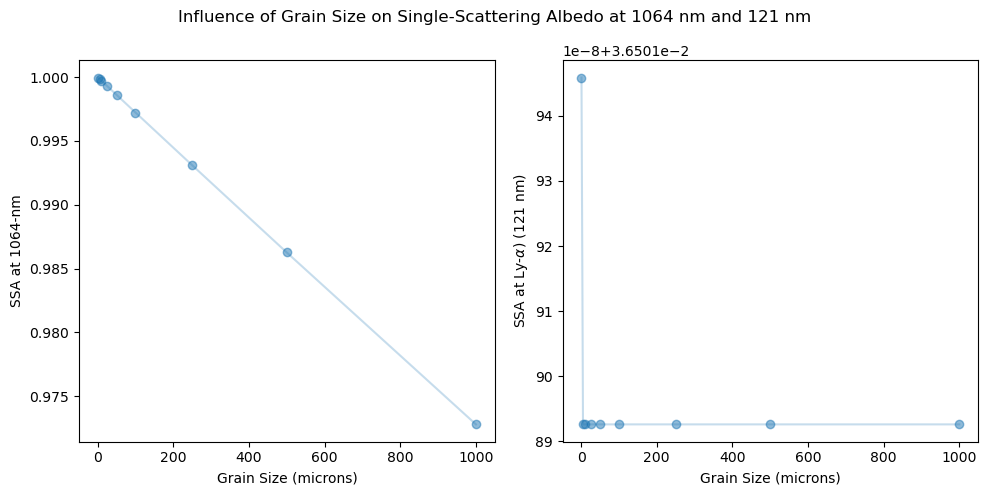

In [25]:
grainSize = [1, 5, 10, 25, 50, 100, 250, 500, 1000]
SSAs_lola = [ice_SSA_calculation(size)[1] for size in grainSize]
SSAs_lya = [ice_SSA_calculation(size)[2] for size in grainSize]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(grainSize, SSAs_lola, color='C0', alpha=0.25)
ax[1].plot(grainSize, SSAs_lya, color='C0', alpha=0.25)
ax[0].scatter(grainSize, SSAs_lola, color='C0', alpha=0.5)
ax[1].scatter(grainSize, SSAs_lya, color='C0', alpha=0.5)
ax[0].set_xlabel("Grain Size (microns)")
ax[1].set_xlabel("Grain Size (microns)")
ax[0].set_ylabel("SSA at 1064-nm")
ax[1].set_ylabel("SSA at Ly-" + r"$\alpha$" + ") (121 nm)")
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fig.suptitle("Influence of Grain Size on Single-Scattering Albedo at 1064 nm and 121 nm")
plt.tight_layout()
plt.show()

<p style='text-align: justify;'> <font size="3">
At the 1064 nm (or 1.064 microns) wavelength of the LOLA instrument, the single-scattering albedo of water ice is at or near one for a large range of grain sizes. The lack of grain size dependence is even more drastic in the Ly-$\alpha$ band, which spans a range of 0.03650189 to 0.03650194. Practically, it seems convenient that the grain size of the ice does not influence the single-scattering albedo too much, since this system has more unknowns than equations to solve for them. That said, a grain size dependence may be more prevalent outside of the range of grain sizes depicted here; a range of 1 micron to 1 mm, though reasonable considering expectations for how surface water ice is stored on the Moon, is narrow. It is important to note that the relationship between grain size and single-scattering albedo, and single-scattering albedo and reflectance (and by extension, grain size and reflectance) is not linear. Although the change in single-scattering albedo with grain size does not seem dramatic in these plots, the modeled reflectance spectra in section 3.3 show considerable changes with different grain size assumptions. 
</font></p>

_________

### 3.2 What role does porosity play in the relationship between single-scattering albedo and reflectance?
<a id="section-3.2"> </a>
Hapke (2008) showed that for a particulate medium in which the average particle size is larger than the wavelength of light, the reflectance of the medium is dependent on porosity. <b> Intuitively, it makes sense that an increase in porosity decreases the reflectance because light does not interact with anything once it enters a pore space. </b> In other words, some amount of the light that would otherwise be available to reflect back towards the instrument sensors is lost in the pore space. The below plots display how porosity affects the measurable reflectances (i.e., normal albedo and hemispherical albedo) given the single-scattering albedo of the material (in the case of LOLA and LAMP, this is the lunar regolith).

In [26]:
def porosity_factor(porosity):
    """
    This function returns the porosity factor, K, given a porosity.
    """
    K = (-np.log(1-1.209*((1 - porosity)**(2/3)))) / (1.209*((1 - porosity)**(2/3)))
    return K


In [27]:
def AlbvSSA(porosity):
    """
    This function computes the reflectance as a function of single-scattering albedo based on a given porosity.
    Note: single-scattering albedo by definition lies between 0 and 1.
    """
    K = porosity_factor(porosity)
    w_mix = np.arange(0,1,10**(-4))
    gamma = np.sqrt(1 - w_mix)
    i = 0
    e = 0
    mu0 = np.cos(e)
    mu = np.cos(i)
    H0 = (1 + (2 * mu0 / K)) / (1 + (2 * mu0 * gamma/ K))
    H = ((1 + (2 * mu / K)) / (1 + (2 * mu * gamma/ K)))
    a_h = (1 - gamma) / (1 + (2 * mu0 * gamma / K))
    a_n = K * (w_mix/4) * (mu0 / (mu0 + mu)) *  H0 * H
    
    return porosity, w_mix, a_h, a_n

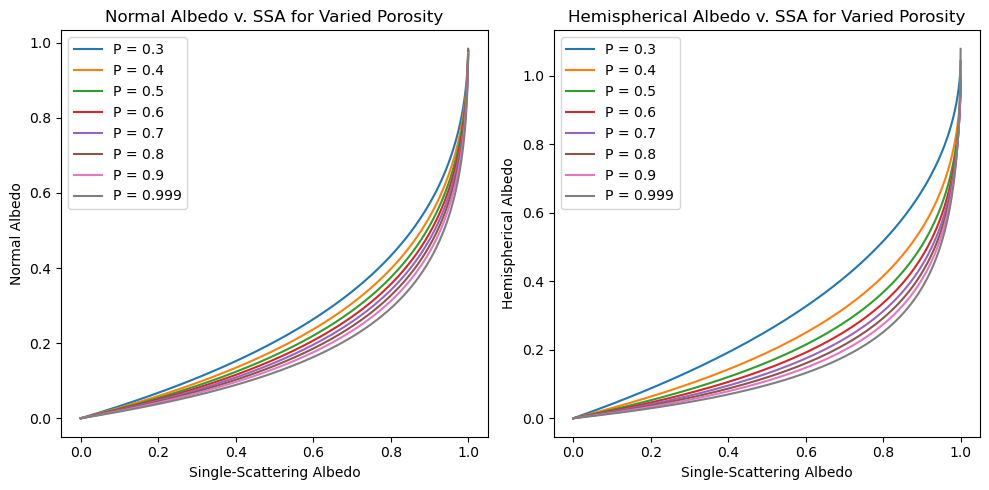

In [28]:
porosity = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]
p = [[AlbvSSA(p) for p in porosity][ii][0] for ii in range(len(porosity))]
w = [[AlbvSSA(p) for p in porosity][ii][1] for ii in range(len(porosity))]
a_h = [[AlbvSSA(p) for p in porosity][ii][2] for ii in range(len(porosity))]
a_n = [[AlbvSSA(p) for p in porosity][ii][3] for ii in range(len(porosity))]

fig, ax = plt.subplots(1,2,figsize=(10,5))
for ii in range(len(a_h)):
    ax[0].plot(w[ii], a_h[ii], label="P = " + str(p[ii]))
    ax[1].plot(w[ii], a_n[ii], label="P = " + str(p[ii]))
ax[0].set_ylabel("Normal Albedo")
ax[1].set_ylabel("Hemispherical Albedo")
ax[0].set_xlabel("Single-Scattering Albedo")
ax[1].set_xlabel("Single-Scattering Albedo")
ax[0].set_title("Normal Albedo v. SSA for Varied Porosity")
ax[1].set_title("Hemispherical Albedo v. SSA for Varied Porosity")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

<p style='text-align: justify;'> <font size="3"> Normal albedo (left) and hemispherical albedo (right) are plotted as a function of single-scattering albedo for a range of porosities from 0.3 - ~1.0. For the same single-scattering albedo, an increase in porosity results in a decrease in reflectance in both the UV and NIR regions of interest. However, the magnitude of the change in reflectance is different for UV and NIR wavelengths. For example, at a single-scattering albedo of 0.6, a 10% increase in porosity from P=0.3 to P=0.4 decreases hemispherical albedo more drastically than normal albedo. This difference in change is an important consideration if we want to unify interpretations of these two datasets. 
</p>

___

### 3.3 How does reflectance change as ice grain size, bulk porosity, and water ice concentration vary?
<a id="section-3.3"> </a>
With an understanding of how ice grain size influences single-scattering albedo, and how single-scattering albedo and porosity influence reflectance, we can explore how the water ice concentration in simulated ice-regolith mixtures impacts normal albedo and hemispherical albedo, and how these reflectance quantities vary with changes in all three parameters. The first set of plots shows modeled spectra of ice-regolith intimate mixtures with the 1064 nm and Ly-$\alpha$ band locations outlined in grey. The standard scenario is: Porosity = 0.5, Ice Mass Fraction = 5%, Ice Grain Size = 5 microns. The regolith grain size is always 51 microns. For a more straightforward visual, the second set of plots shows average reflectances at the 1064 nm and Ly-$\alpha$ band locations as a function of ice grain size, bulk porosity, and ice mass fraction.

In [29]:
def albedo_factor(w_ice, ice_mass_frac, D_ice, D_reg):
    """
    This function computes the albedo factor. First, it uses the solid densities of ice and regolith to calculate endmember volumetric abundance, 
    which is then used to calculate the single-scattering albedo of the mixture, and by extension, the albedo factor. Values for the single-scattering
    albedo of lunar regolith at UV and NIR wavelengths are taken from Raut et al. (2018) and Barker et al. (2022), respectively.
    """
    rho_ice = 970
    rho_reg = 2000
    Mice = ice_mass_frac
    Mreg = 1 - ice_mass_frac 
    v_ice = Mice / rho_ice
    v_reg = Mreg / rho_reg
    
    w_reg_uv = 0.1
    w_mix_uv = ((v_ice/D_ice) * w_ice + (v_reg/D_reg) * w_reg_uv) / ((v_ice/D_ice) + (v_reg/D_reg))
    gamma_uv = np.sqrt(1 - w_mix_uv)
    
    w_reg_nir = 0.5
    w_mix_nir = ((v_ice/D_ice) * w_ice + (v_reg/D_reg) * w_reg_nir) / ((v_ice/D_ice) + (v_reg/D_reg))
    gamma_nir = np.sqrt(1 - w_mix_nir)

    return w_mix_uv, gamma_uv, w_mix_nir, gamma_nir

In [30]:
def refl_int_mix(porosity, ice_mass_frac, ice_diam, reg_diam):
    """
    This function computes normal albedo and hemispherical albedo of intimate ice-regolith mixtures for a given porosity, compositional endmember
    mass fraction, and compositional endmember grain size.
    """
    w_ice = ice_SSA_calculation(ice_diam)[3]
    K = porosity_factor(porosity)
    w_mix_uv, gamma_uv, w_mix_nir, gamma_nir = albedo_factor(w_ice, ice_mass_frac, ice_diam, reg_diam)
    w_mix = (w_mix_uv, w_mix_nir)
    
    ## illumination-viewing geometry
    e = 0
    i = 0
    mu0 = np.cos(e)
    mu = np.cos(i)
    
    ## H-function for multiple scattering
    H0 = (1 + (2 * mu0 / K)) / (1 + (2 * mu0 * gamma_nir/ K))
    H = ((1 + (2 * mu / K)) / (1 + (2 * mu * gamma_nir/ K)))

    ## normal and hemispherical albedo
    a_n = K * (w_mix_nir/4) * (mu0 / (mu0 + mu)) *  H0 * H
    a_h = (1 - gamma_uv) / (1 + (2 * mu0 * gamma_uv / K))

    return a_h, a_n, w_mix

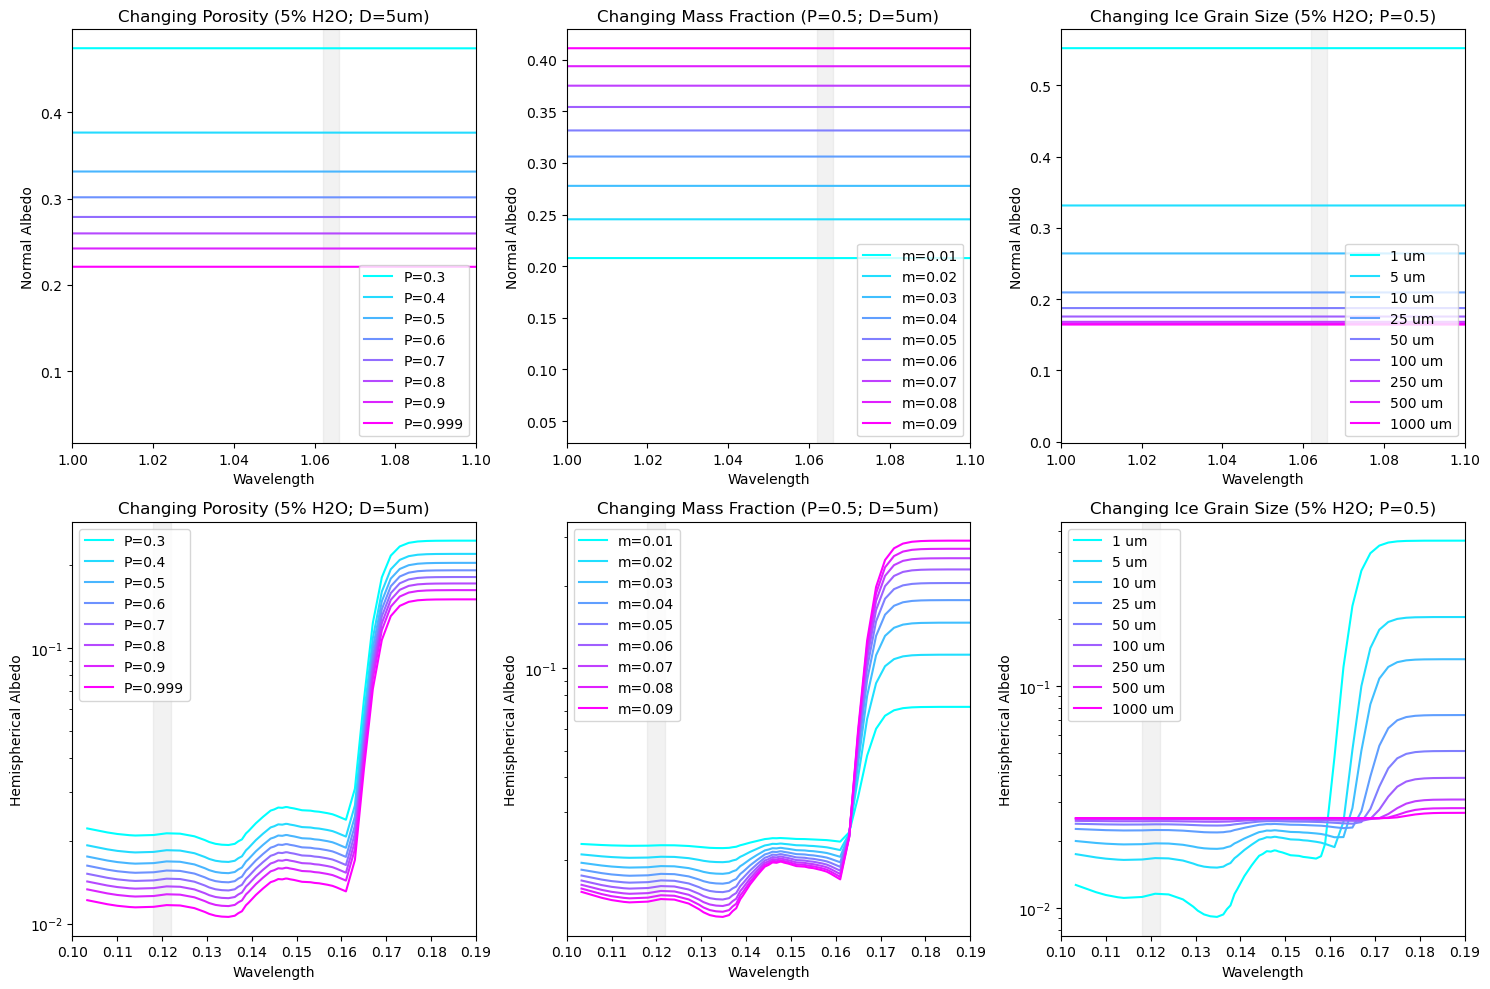

In [31]:
massFrac = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

changeLYA = [[[refl_int_mix(p, 0.05, 5, 51) for p in porosity][ii][0] for ii in range(len(porosity))],
           [[refl_int_mix(0.5, m, 5, 51) for m in massFrac][ii][0] for ii in range(len(massFrac))],
           [[refl_int_mix(0.5, 0.05, d, 51) for d in grainSize][ii][0] for ii in range(len(grainSize))]]
        
changeLOLA = [[[refl_int_mix(p, 0.05, 5, 51) for p in porosity][ii][1] for ii in range(len(porosity))],
            [[refl_int_mix(0.5, m, 5, 51) for m in massFrac][ii][1] for ii in range(len(massFrac))],
            [[refl_int_mix(0.5, 0.05, d, 51) for d in grainSize][ii][1] for ii in range(len(grainSize))]]
       
changeSSA = [[[refl_int_mix(p, 0.05, 5, 51) for p in porosity][ii][2] for ii in range(len(porosity))],
            [[refl_int_mix(0.5, m, 5, 51) for m in massFrac][ii][2] for ii in range(len(massFrac))],
            [[refl_int_mix(0.5, 0.05, d, 51) for d in grainSize][ii][2] for ii in range(len(grainSize))]]

p_legend = ["P=" + str(el) for el in porosity]
m_legend = ["m=" + str(el) for el in massFrac]
d_legend = [str(el) + " um" for el in grainSize]

colors_p = plt.cm.cool(np.linspace(0, 1, len(p_legend)))
colors_m = plt.cm.cool(np.linspace(0, 1, len(m_legend)))
colors_d = plt.cm.cool(np.linspace(0, 1, len(d_legend)))

fig, ax = plt.subplots(2,3,figsize=(15,10))

for ii in range(len(changeLOLA[0])):
    ax[0,0].plot(wl, changeLOLA[0][ii], c=colors_p[ii], label = p_legend[ii])
for ii in range(len(changeLOLA[1])):
    ax[0,1].plot(wl, changeLOLA[1][ii], c=colors_m[ii], label = m_legend[ii])
for ii in range(len(changeLOLA[2])):
    ax[0,2].plot(wl, changeLOLA[2][ii], c=colors_d[ii], label = d_legend[ii])

for ii in range(len(changeLYA[0])):
    ax[1,0].plot(wl, changeLYA[0][ii], c=colors_p[ii], label = p_legend[ii])
for ii in range(len(changeLYA[1])):
    ax[1,1].plot(wl, changeLYA[1][ii], c=colors_m[ii], label = m_legend[ii])
for ii in range(len(changeLYA[2])):
    ax[1,2].plot(wl, changeLYA[2][ii], c=colors_d[ii], label = d_legend[ii])

ax[0,0].axvspan(1.062, 1.066, color='silver', alpha=0.2)
ax[0,1].axvspan(1.062, 1.066, color='silver', alpha=0.2)
ax[0,2].axvspan(1.062, 1.066, color='silver', alpha=0.2)

ax[1,0].axvspan(0.118, 0.122, color='silver', alpha=0.2)
ax[1,1].axvspan(0.118, 0.122, color='silver', alpha=0.2)
ax[1,2].axvspan(0.118, 0.122, color='silver', alpha=0.2)

ax[0,0].set_xlabel("Wavelength")
ax[0,1].set_xlabel("Wavelength")
ax[0,2].set_xlabel("Wavelength")
ax[0,0].set_ylabel("Normal Albedo")
ax[0,1].set_ylabel("Normal Albedo")
ax[0,2].set_ylabel("Normal Albedo")
ax[0,0].set_title("Changing Porosity (5% H2O; D=5um)")
ax[0,1].set_title("Changing Mass Fraction (P=0.5; D=5um)")
ax[0,2].set_title("Changing Ice Grain Size (5% H2O; P=0.5)")
ax[0,0].set_xlim(1.0,1.1)
ax[0,1].set_xlim(1.0,1.1)
ax[0,2].set_xlim(1.0,1.1)
ax[0,0].legend(loc='lower right')
ax[0,1].legend(loc='lower right')
ax[0,2].legend(loc='lower right')

ax[1,0].set_xlabel("Wavelength")
ax[1,1].set_xlabel("Wavelength")
ax[1,2].set_xlabel("Wavelength")
ax[1,0].set_ylabel("Hemispherical Albedo")
ax[1,1].set_ylabel("Hemispherical Albedo")
ax[1,2].set_ylabel("Hemispherical Albedo")
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_yscale('log')
ax[1,0].set_title("Changing Porosity (5% H2O; D=5um)")
ax[1,1].set_title("Changing Mass Fraction (P=0.5; D=5um)")
ax[1,2].set_title("Changing Ice Grain Size (5% H2O; P=0.5)")
ax[1,0].set_xlim(0.10,0.19)
ax[1,1].set_xlim(0.10,0.19)
ax[1,2].set_xlim(0.10,0.19)
ax[1,0].legend(loc='upper left')
ax[1,1].legend(loc='upper left')
ax[1,2].legend(loc='upper left')

plt.tight_layout()
plt.show()

<p style='text-align: justify;'> <font size="3"> These six plots display modeled reflectance spectra for ice-regolith mixtures at 1064 nm (grey band, top row) and Ly-a (grey band, bottom row) wavelengths, for changing porosity (left column), changing ice mass fraction (middle column), and changing ice grain size (right column). Water ice displays a prominent absorption edge at ~165 nm, which is reflected in the hemispherical albedo plots. The right column, as expected, displays a decrease in albedo for increasing porosity, which occurs in both wavelength regions. The middle column confirms that, since water ice has a higher 1064 nm albedo than lunar regolith and a lower Ly-a albedo than lunar regolith, increasing the mass fraction of water ice in the mixture increases and decreases the overall reflectance at 1064 nm and Ly-a, respectively. Finally, in the third column, we see increasing the grain size of the ice decreases and increases the albedo at 1064 nm and Ly-a, respectively.
</font></p>

In [32]:
def band_parameters(wl, a_h, a_n):
    """
    Returns average 1064 nm and Ly-a albedo.
    """
    
    lya_mean = np.mean([alb for alb in a_h[5:8]])
    lola_mean = np.mean([alb for alb in a_n[129:131]])
    
    return lola_mean, lya_mean

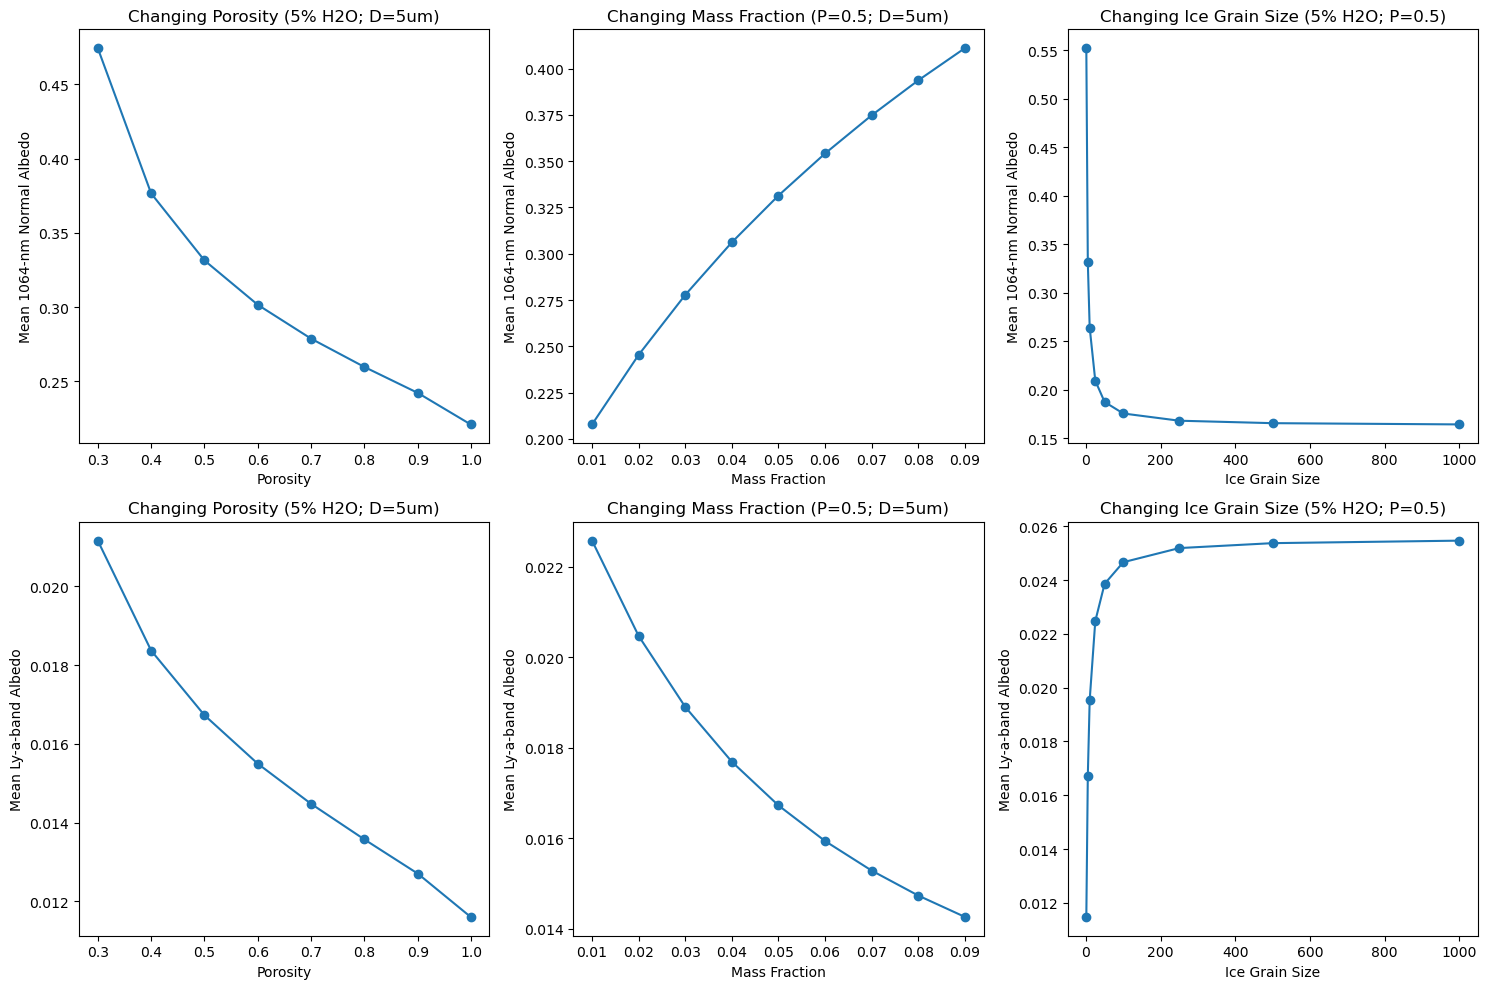

In [33]:
changeP = [band_parameters(wl, changeLYA[0][ii], changeLOLA[0][ii]) for ii in range(len(changeLYA[0]))]
changeM = [band_parameters(wl, changeLYA[1][ii], changeLOLA[1][ii]) for ii in range(len(changeLYA[1]))]
changeD = [band_parameters(wl, changeLYA[2][ii], changeLOLA[2][ii]) for ii in range(len(changeLYA[2]))]

changeP_avgLOLA, changeP_avgLYA = ([changeP[ii][0] for ii in range(len(changeP))], [changeP[ii][1] for ii in range(len(changeP))])
changeM_avgLOLA, changeM_avgLYA = ([changeM[ii][0] for ii in range(len(changeM))], [changeM[ii][1] for ii in range(len(changeM))])
changeD_avgLOLA, changeD_avgLYA = ([changeD[ii][0] for ii in range(len(changeD))], [changeD[ii][1] for ii in range(len(changeD))])

fig, ax = plt.subplots(2,3,figsize=(15,10))

ax[0,0].plot(porosity, changeP_avgLOLA)
ax[0,1].plot(massFrac, changeM_avgLOLA)
ax[0,2].plot(grainSize, changeD_avgLOLA)
ax[0,0].scatter(porosity, changeP_avgLOLA, label = " 5% H2O\n 5 um ice\n 51 um regolith")
ax[0,1].scatter(massFrac, changeM_avgLOLA, label = " P = 0.5\n 5 um ice\n 51 um regolith")
ax[0,2].scatter(grainSize, changeD_avgLOLA, label = " P = 0.5\n 5% H2O\n 51 um regolith")
ax[0,0].set_ylabel("Mean 1064-nm Normal Albedo")
ax[0,1].set_ylabel("Mean 1064-nm Normal Albedo")
ax[0,2].set_ylabel("Mean 1064-nm Normal Albedo")
ax[0,0].set_xlabel("Porosity")
ax[0,1].set_xlabel("Mass Fraction")
ax[0,2].set_xlabel("Ice Grain Size")
ax[0,0].set_title("Changing Porosity (5% H2O; D=5um)")
ax[0,1].set_title("Changing Mass Fraction (P=0.5; D=5um)")
ax[0,2].set_title("Changing Ice Grain Size (5% H2O; P=0.5)")

ax[1,0].plot(porosity, changeP_avgLYA)
ax[1,1].plot(massFrac, changeM_avgLYA)
ax[1,2].plot(grainSize, changeD_avgLYA)
ax[1,0].scatter(porosity, changeP_avgLYA, label = " 5% H2O\n 5 um ice\n 51 um regolith")
ax[1,1].scatter(massFrac, changeM_avgLYA, label = " P = 0.5\n 5 um ice\n 51 um regolith")
ax[1,2].scatter(grainSize, changeD_avgLYA, label = " P = 0.5\n 5% H2O\n 51 um regolith")
ax[1,0].set_ylabel("Mean Ly-a-band Albedo")
ax[1,1].set_ylabel("Mean Ly-a-band Albedo")
ax[1,2].set_ylabel("Mean Ly-a-band Albedo")
ax[1,0].set_xlabel("Porosity")
ax[1,1].set_xlabel("Mass Fraction")
ax[1,2].set_xlabel("Ice Grain Size")
ax[1,0].set_title("Changing Porosity (5% H2O; D=5um)")
ax[1,1].set_title("Changing Mass Fraction (P=0.5; D=5um)")
ax[1,2].set_title("Changing Ice Grain Size (5% H2O; P=0.5)")

plt.tight_layout()
plt.show()

<p style='text-align: justify;'> <font size="3">
As a more straightforward visualization, this plot shows directly how the 1064 nm (top row) and Ly-a (bottom row) wavelength band averages vary as a function of porosity (left column), mass fraction (middle column), and ice grain size (right column) for an otherwise equivalent scenario of porosity equal to 0.5, H$_{2}$O mass fraction of 0.05 (5%), and ice grain size of 5 microns. While increasing porosity causes reflectance to decrease in both wavelength regions, increasing ice mass fraction and ice grain size causes opposite responses in the modeled 1064 nm and Ly-a albedo.</font></p>